In [1]:
import pandas as pd
# load in deals merged data 
def load_csv_from_github(file_name):
 base_url = "https://raw.githubusercontent.com/marymorkos/SalesPlaybookDS5640/refs/heads/main/"
 return pd.read_csv(base_url + file_name)

df = load_csv_from_github("deals_centric_merged.csv")

In [2]:

# Define selected features
selected_features = [
    'Annual Revenue', 
    'Number of times contacted', 
    'Amount in company currency', 
    'Amount', 
    'Forecast amount', 
    'Number of Pageviews', 
    'Number of Employees', 
    'Number of Sessions', 
    'Days to close', 
    'Number of Form Submissions', 
    'State/Region', 
    'Deal owner', 
    'Primary Sub-Industry', 
    'Deal source attribution 2', 
    'Year Founded', 
    'Deal Type', 
    'Industry',
    'ICP Fit Level'
]

target_column = 'Is Closed Won'  

df_selected = df[selected_features + [target_column]]
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Annual Revenue              557 non-null    float64
 1   Number of times contacted   561 non-null    float64
 2   Amount in company currency  573 non-null    float64
 3   Amount                      573 non-null    float64
 4   Forecast amount             573 non-null    float64
 5   Number of Pageviews         561 non-null    float64
 6   Number of Employees         561 non-null    float64
 7   Number of Sessions          561 non-null    float64
 8   Days to close               593 non-null    float64
 9   Number of Form Submissions  561 non-null    float64
 10  State/Region                557 non-null    object 
 11  Deal owner                  558 non-null    object 
 12  Primary Sub-Industry        321 non-null    object 
 13  Deal source attribution 2   587 non

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Make a copy of the dataframe
df_imputed = df_selected.copy()

# 1. Categorical features with special handling
# Deal owner - preserve signal that missing owners correlate with lost deals
df_imputed['Deal owner'] = df_imputed['Deal owner'].fillna('No Owner Assigned')

# Primary Sub-Industry - high missingness rate (46%)
df_imputed['Primary Sub-Industry'] = df_imputed['Primary Sub-Industry'].fillna('Unspecified')

# ICP Fit Level - create an "Unknown" category
df_imputed['ICP Fit Level'] = df_imputed['ICP Fit Level'].fillna('Unknown')

# 2. Other categorical features with mode imputation
categorical_features = ['State/Region', 'Deal source attribution 2', 'Industry', 'Deal Type']
for col in categorical_features:
    if df_imputed[col].isna().sum() > 0:
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])

# 3. Handle Year Founded separately - using median imputation
# Year is a discrete value and median is more appropriate than KNN for this type of data
if df_imputed['Year Founded'].isna().sum() > 0:
    year_median = df_imputed['Year Founded'].median()
    df_imputed['Year Founded'] = df_imputed['Year Founded'].fillna(year_median)

# 4. Remaining numerical features with KNN imputation
numerical_features = [
    'Annual Revenue', 'Number of times contacted', 'Amount in company currency',
    'Amount', 'Forecast amount', 'Number of Pageviews', 'Number of Employees',
    'Number of Sessions', 'Number of Form Submissions'
]
num_df = df_imputed[numerical_features].copy()
imputer = KNNImputer(n_neighbors=5)
df_imputed[numerical_features] = imputer.fit_transform(num_df)

# Quick summary of the imputed dataframe
print(f"Imputation complete. Shape: {df_imputed.shape}")

Imputation complete. Shape: (593, 19)


In [4]:
# Code to check the number of unique categories in each categorical column
categorical_columns = [
    'State/Region', 
    'Deal owner', 
    'Primary Sub-Industry', 
    'Deal source attribution 2', 
    'Deal Type', 
    'Industry',
    'ICP Fit Level'
]

# Create a dictionary to store the results
category_counts = {}

# Loop through each categorical column
for col in categorical_columns:
    if col in df_imputed.columns:
        # Count unique values
        unique_count = df_imputed[col].nunique()
        # Get value counts to see distribution
        value_counts = df_imputed[col].value_counts()
        # Store in dictionary
        category_counts[col] = {
            'unique_count': unique_count,
            'top_5_categories': value_counts.head(5).to_dict()
        }

# Display the results
for col, stats in category_counts.items():
    print(f"\n{col}:")
    print(f"  Number of unique categories: {stats['unique_count']}")
    print("  Top 5 most frequent categories:")
    for category, count in stats['top_5_categories'].items():
        print(f"    - {category}: {count}")


State/Region:
  Number of unique categories: 86
  Top 5 most frequent categories:
    - New York: 83
    - CA: 42
    - Texas: 41
    - California: 37
    - Georgia: 36

Deal owner:
  Number of unique categories: 25
  Top 5 most frequent categories:
    - Deal_3d3dc242: 190
    - Deal_96aa4419: 80
    - Deal_bb6f872e: 77
    - Deal_3cf008ff: 35
    - No Owner Assigned: 35

Primary Sub-Industry:
  Number of unique categories: 69
  Top 5 most frequent categories:
    - Unspecified: 272
    - Banking: 29
    - Freight & Logistics Services: 29
    - Call Centers & Business Centers: 23
    - Management Consulting: 16

Deal source attribution 2:
  Number of unique categories: 13
  Top 5 most frequent categories:
    - SymTrain EE name: 198
    - Referral Partner: 124
    - Other: 106
    - Event: 78
    - PAM: 28

Deal Type:
  Number of unique categories: 4
  Top 5 most frequent categories:
    - New: 438
    - Renewal: 83
    - Growth: 58
    - PS: 14

Industry:
  Number of unique categori

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime

# Start with our imputed dataframe
df_processed = df_imputed.copy()

# Feature Engineering Step
# 1. Calculate Company Age (current year - founded year)
current_year = datetime.now().year  # Get current year
df_processed['Company_Age'] = current_year - df_processed['Year Founded']
# Drop the original Year Founded column as we're replacing it
df_processed.drop('Year Founded', axis=1, inplace=True)

# 2. Contact Frequency (with handling for zero values)
df_processed['Contact_Frequency'] = np.where(
    df_processed['Days to close'] > 0,
    df_processed['Number of times contacted'] / df_processed['Days to close'],
    df_processed['Number of times contacted']  # If days to close is 0, just use contact count
)

# 3. Revenue per Employee
df_processed['Revenue_per_Employee'] = df_processed['Annual Revenue'] / (df_processed['Number of Employees'] + 1)  # Adding 1 to avoid division by zero

# 4. Submission Conversion Rate
df_processed['Submission_Conversion_Rate'] = np.where(
    df_processed['Number of Sessions'] > 0,
    df_processed['Number of Form Submissions'] / df_processed['Number of Sessions'],
    0  # If no sessions, set to 0
)

# 5. Page Depth
df_processed['Page_Depth'] = np.where(
    df_processed['Number of Sessions'] > 0,
    df_processed['Number of Pageviews'] / df_processed['Number of Sessions'],
    0  # If no sessions, set to 0
)

# Now we're ready for the train/test split followed by scaling and encoding
# IMPORTANT: Split data first to prevent data leakage
# Extract the target
y = df_processed['Is Closed Won']
X = df_processed.drop('Is Closed Won', axis=1)

# Create train/test split before any scaling/encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Recombine for processing, but keep track of indices
train_indices = X_train.index
test_indices = X_test.index
df_train = pd.concat([X_train, y_train.rename('Is Closed Won')], axis=1)
df_test = pd.concat([X_test, y_test.rename('Is Closed Won')], axis=1)

# Step 1: Handle numerical scaling
numerical_columns = [
    'Annual Revenue', 'Number of times contacted', 'Amount in company currency',
    'Amount', 'Forecast amount', 'Number of Pageviews', 'Number of Employees',
    'Number of Sessions', 'Days to close', 'Number of Form Submissions',
    'Company_Age', 'Contact_Frequency', 'Revenue_per_Employee', 
    'Submission_Conversion_Rate', 'Page_Depth'
]

# Fit scaler only on training data
scaler = StandardScaler()
df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

# Step 3: Handle categorical encoding based on cardinality
# Low-cardinality columns: One-hot encoding
low_cardinality_cols = ['Deal Type', 'ICP Fit Level']

# Get all categories from both train and test to ensure consistency
all_categories = {}
for col in low_cardinality_cols:
    all_categories[col] = set(df_train[col].unique()).union(set(df_test[col].unique()))

# Apply one-hot encoding with drop_first=True
for col in low_cardinality_cols:
    # Create dummy variables - important to use dummy_na=True to handle NaN values
    dummies_train = pd.get_dummies(df_train[col], prefix=col, drop_first=True, dummy_na=True)
    dummies_test = pd.get_dummies(df_test[col], prefix=col, drop_first=True, dummy_na=True)
    
    # Ensure test has all columns from training
    missing_cols = set(dummies_train.columns) - set(dummies_test.columns)
    for c in missing_cols:
        dummies_test[c] = 0
    
    # Ensure columns are in the same order
    dummies_test = dummies_test[dummies_train.columns]
    
    # Concatenate
    df_train = pd.concat([df_train, dummies_train], axis=1)
    df_test = pd.concat([df_test, dummies_test], axis=1)
    
    # Drop original column
    df_train.drop(col, axis=1, inplace=True)
    df_test.drop(col, axis=1, inplace=True)

# Medium-cardinality columns: One-hot encoding
medium_cardinality_cols = ['Deal owner', 'Deal source attribution 2']

# Apply same process as above
for col in medium_cardinality_cols:
    dummies_train = pd.get_dummies(df_train[col], prefix=col, drop_first=True, dummy_na=True)
    dummies_test = pd.get_dummies(df_test[col], prefix=col, drop_first=True, dummy_na=True)
    
    # Ensure test has all columns from training
    missing_cols = set(dummies_train.columns) - set(dummies_test.columns)
    for c in missing_cols:
        dummies_test[c] = 0
    
    # Ensure columns are in the same order
    dummies_test = dummies_test[dummies_train.columns]
    
    df_train = pd.concat([df_train, dummies_train], axis=1)
    df_test = pd.concat([df_test, dummies_test], axis=1)
    
    df_train.drop(col, axis=1, inplace=True)
    df_test.drop(col, axis=1, inplace=True)

# High-cardinality columns: Frequency Encoding
high_cardinality_cols = ['State/Region', 'Primary Sub-Industry', 'Industry']

# Create copies of dataframes to modify
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()

# Calculate frequency encoding on training data
for col in high_cardinality_cols:
    # Calculate frequencies from training data
    frequency_map = df_train[col].value_counts(normalize=True)
    
    # Apply frequency encoding to both train and test sets
    df_train_encoded[f'{col}_freq'] = df_train[col].map(frequency_map)
    
    # For test data, handle unseen categories by assigning a small value
    # (alternatively, you could use a default of 0 or the minimum frequency)
    df_test_encoded[f'{col}_freq'] = df_test[col].map(lambda x: frequency_map.get(x, 1/(len(df_train)+1)))
    
    # Drop original column
    df_train_encoded.drop(col, axis=1, inplace=True)
    df_test_encoded.drop(col, axis=1, inplace=True)

# Recombine for final result if needed
df_processed_final = pd.concat([df_train_encoded, df_test_encoded])

# Optional: Print the final processed dataframe shape
print(f"Final processed dataframe shape: {df_processed_final.shape}")

# Separate back to X_train, X_test if needed for modeling
X_train_processed = df_train_encoded.drop('Is Closed Won', axis=1)
X_test_processed = df_test_encoded.drop('Is Closed Won', axis=1)

Final processed dataframe shape: (593, 63)


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the initial class distribution
print("Original training dataset shape:", Counter(y_train))

# Apply SMOTE to balance the training data
# We'll only apply SMOTE to the training data to maintain test set integrity
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Check the class distribution after SMOTE
print("Balanced training dataset shape:", Counter(y_train_balanced))

# Keep test data unchanged for proper evaluation
X_test_balanced = X_test_processed
y_test_balanced = y_test

Original training dataset shape: Counter({False: 348, True: 126})
Balanced training dataset shape: Counter({True: 348, False: 348})


Starting model training and evaluation...

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7227
ROC AUC: 0.7838
Training time: 9.37 seconds

Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.74      0.80        87
        True       0.49      0.69      0.57        32

    accuracy                           0.72       119
   macro avg       0.68      0.71      0.68       119
weighted avg       0.76      0.72      0.73       119



c:\Users\laura\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


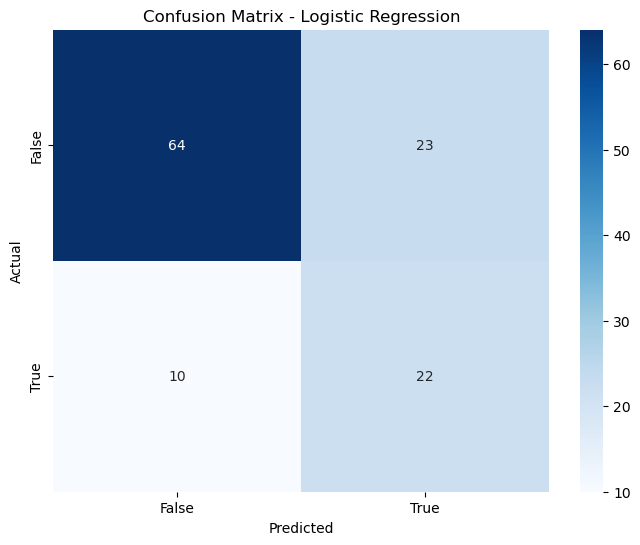

Best parameters: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}

Training Random Forest...

Random Forest Results:
Accuracy: 0.8824
ROC AUC: 0.8955
Training time: 64.88 seconds

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.92      0.92        87
        True       0.78      0.78      0.78        32

    accuracy                           0.88       119
   macro avg       0.85      0.85      0.85       119
weighted avg       0.88      0.88      0.88       119



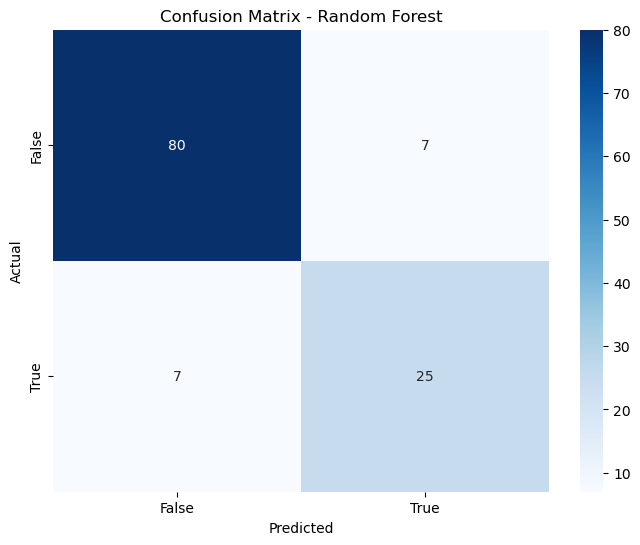

Best parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}

Training XGBoost...

XGBoost Results:
Accuracy: 0.8739
ROC AUC: 0.9116
Training time: 159.46 seconds

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.92      0.91        87
        True       0.77      0.75      0.76        32

    accuracy                           0.87       119
   macro avg       0.84      0.83      0.84       119
weighted avg       0.87      0.87      0.87       119



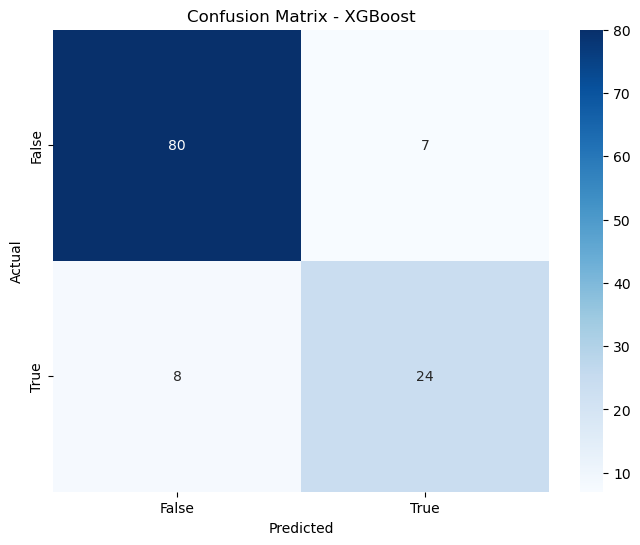

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}

Model Comparison:
                 Model  Accuracy   ROC AUC  Training Time
2              XGBoost  0.873950  0.911638     159.459647
1        Random Forest  0.882353  0.895474      64.881316
0  Logistic Regression  0.722689  0.783764       9.373536


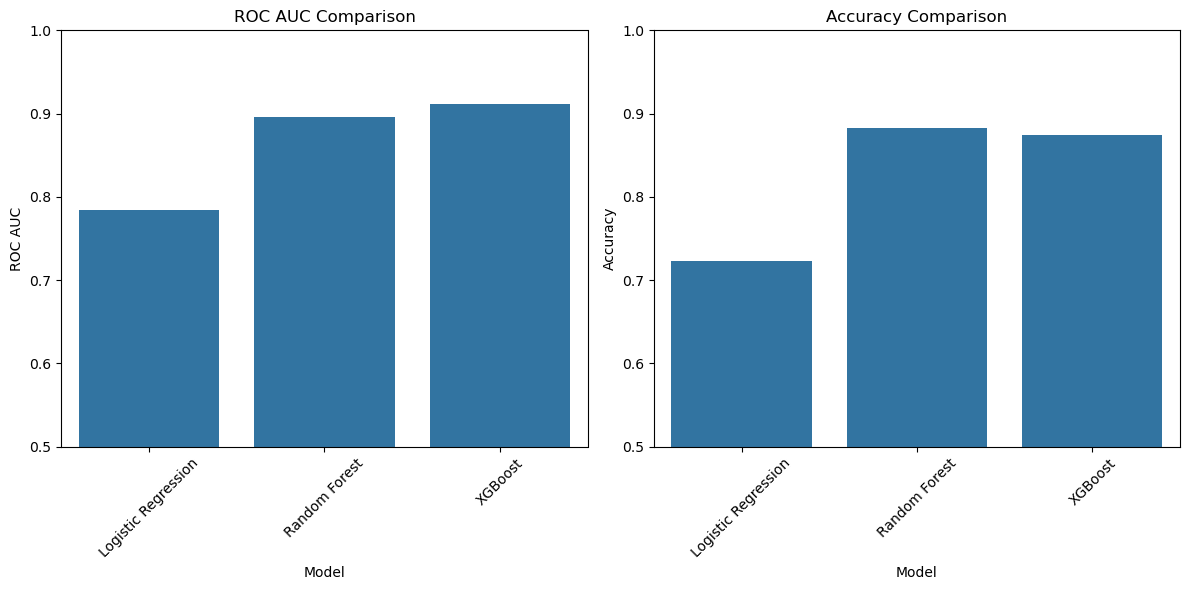


Best performing model: XGBoost with ROC AUC of 0.9116


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Define a function to evaluate and display model results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Start timing
    start_time = time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    training_time = time() - start_time
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['False', 'True'], 
                yticklabels=['False', 'True'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # If the model supports feature importance, display top features
    if hasattr(model, 'feature_importances_') or hasattr(model, 'coef_'):
        print("\nTop 10 Important Features:")
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            importances = np.abs(model.coef_[0])
        
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print(feature_importance.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
        plt.title(f'Top 10 Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
    
    return model, accuracy, auc, training_time

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. Logistic Regression with Grid Search
lr_param_grid = {
    'C': [0.1, 0.5, 0.8, 1, 1.2, 1.5, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'class_weight': [None, 'balanced']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=lr_param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# 2. Random Forest with Grid Search
rf_param_grid = {
    'n_estimators': [300, 500, 600],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)


# 3. XGBoost with Grid Search
xgb_param_grid = {
    'n_estimators': [150, 200, 350],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit and evaluate each model
print("Starting model training and evaluation...")

# List to store results
results = []

# Logistic Regression
print("\nTraining Logistic Regression...")
lr_best, lr_acc, lr_auc, lr_time = evaluate_model(
    lr_grid, X_train_balanced, X_test_processed, y_train_balanced, y_test, "Logistic Regression"
)
results.append(('Logistic Regression', lr_acc, lr_auc, lr_time))
print(f"Best parameters: {lr_grid.best_params_}")

# Random Forest
print("\nTraining Random Forest...")
rf_best, rf_acc, rf_auc, rf_time = evaluate_model(
    rf_grid, X_train_balanced, X_test_processed, y_train_balanced, y_test, "Random Forest"
)
results.append(('Random Forest', rf_acc, rf_auc, rf_time))
print(f"Best parameters: {rf_grid.best_params_}")

# XGBoost
print("\nTraining XGBoost...")
xgb_best, xgb_acc, xgb_auc, xgb_time = evaluate_model(
    xgb_grid, X_train_balanced, X_test_processed, y_train_balanced, y_test, "XGBoost"
)
results.append(('XGBoost', xgb_acc, xgb_auc, xgb_time))
print(f"Best parameters: {xgb_grid.best_params_}")

# Compare all models
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'ROC AUC', 'Training Time'])
print("\nModel Comparison:")
print(results_df.sort_values('ROC AUC', ascending=False))

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='ROC AUC', data=results_df)
plt.title('ROC AUC Comparison')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Accuracy Comparison')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Identify the best model
best_model_idx = results_df['ROC AUC'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model_name} with ROC AUC of {results_df.loc[best_model_idx, 'ROC AUC']:.4f}")


Top 20 Important Features for Random Forest:
                                       Feature  Importance
2                   Amount in company currency    0.061058
4                              Forecast amount    0.058713
3                                       Amount    0.058171
11                           Contact_Frequency    0.058078
1                    Number of times contacted    0.052641
9                   Number of Form Submissions    0.049119
8                                Days to close    0.048043
5                          Number of Pageviews    0.047740
61                               Industry_freq    0.044165
13                  Submission_Conversion_Rate    0.043911
14                                  Page_Depth    0.043227
7                           Number of Sessions    0.040603
6                          Number of Employees    0.038415
0                               Annual Revenue    0.036717
10                                 Company_Age    0.036699
60        

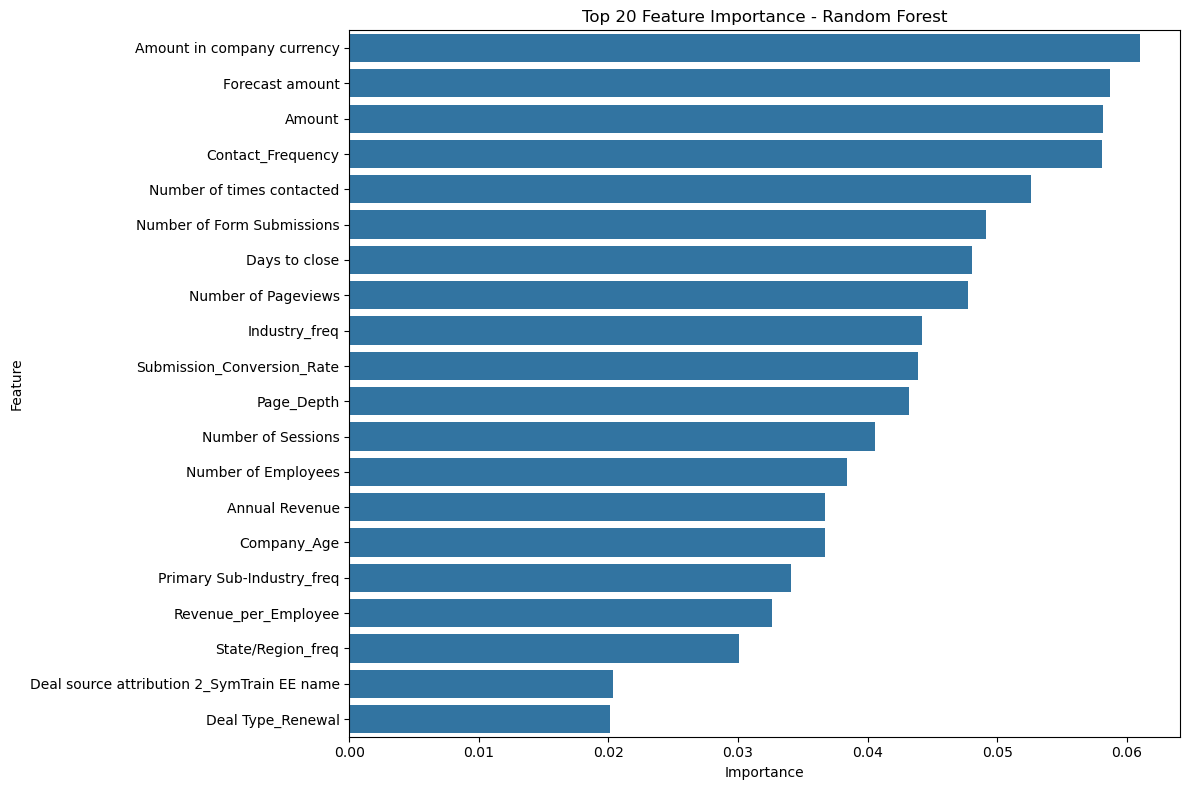


Top 20 Important Features for XGBoost:
                                       Feature  Importance
44                Deal owner_No Owner Assigned    0.115148
47    Deal source attribution 2_Email campaign    0.069303
16                                Deal Type_PS    0.056889
9                   Number of Form Submissions    0.056489
26                    Deal owner_Deal_3cf008ff    0.042264
5                          Number of Pageviews    0.039792
14                                  Page_Depth    0.031549
56  Deal source attribution 2_SymTrain EE name    0.030748
60                   Primary Sub-Industry_freq    0.030269
4                              Forecast amount    0.029261
32                    Deal owner_Deal_96aa4419    0.025486
37                    Deal owner_Deal_bb6f872e    0.024813
7                           Number of Sessions    0.024713
17                           Deal Type_Renewal    0.023944
1                    Number of times contacted    0.023838
2               

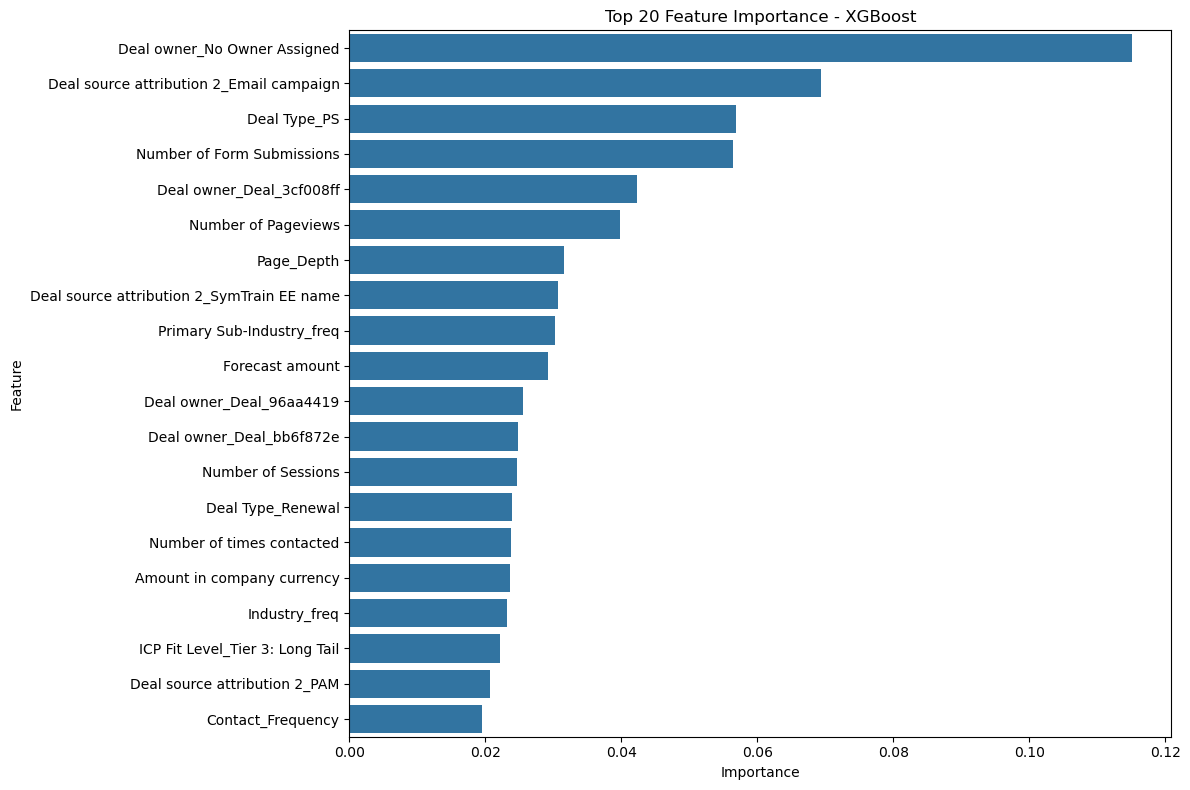

In [37]:
# Get the best Random Forest model
rf_best_model = rf_grid.best_estimator_

# Get the best XGBoost model
xgb_best_model = xgb_grid.best_estimator_

# Function to display feature importances
def display_feature_importance(model, X_train, model_name, top_n=20):
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print(f"{model_name} does not have feature_importances_ attribute")
        return
    
    # Create DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Print top N features
    print(f"\nTop {top_n} Important Features for {model_name}:")
    print(feature_importance.head(top_n))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(top_n))
    plt.title(f'Top {top_n} Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Display feature importances for Random Forest
rf_importances = display_feature_importance(rf_best_model, X_train_balanced, "Random Forest", top_n=20)

# Display feature importances for XGBoost
xgb_importances = display_feature_importance(xgb_best_model, X_train_balanced, "XGBoost", top_n=20)

Shape of shap_values: (696, 62, 2)
Shape after selecting class 1: (696, 62)
Shape of mean values: (62,)


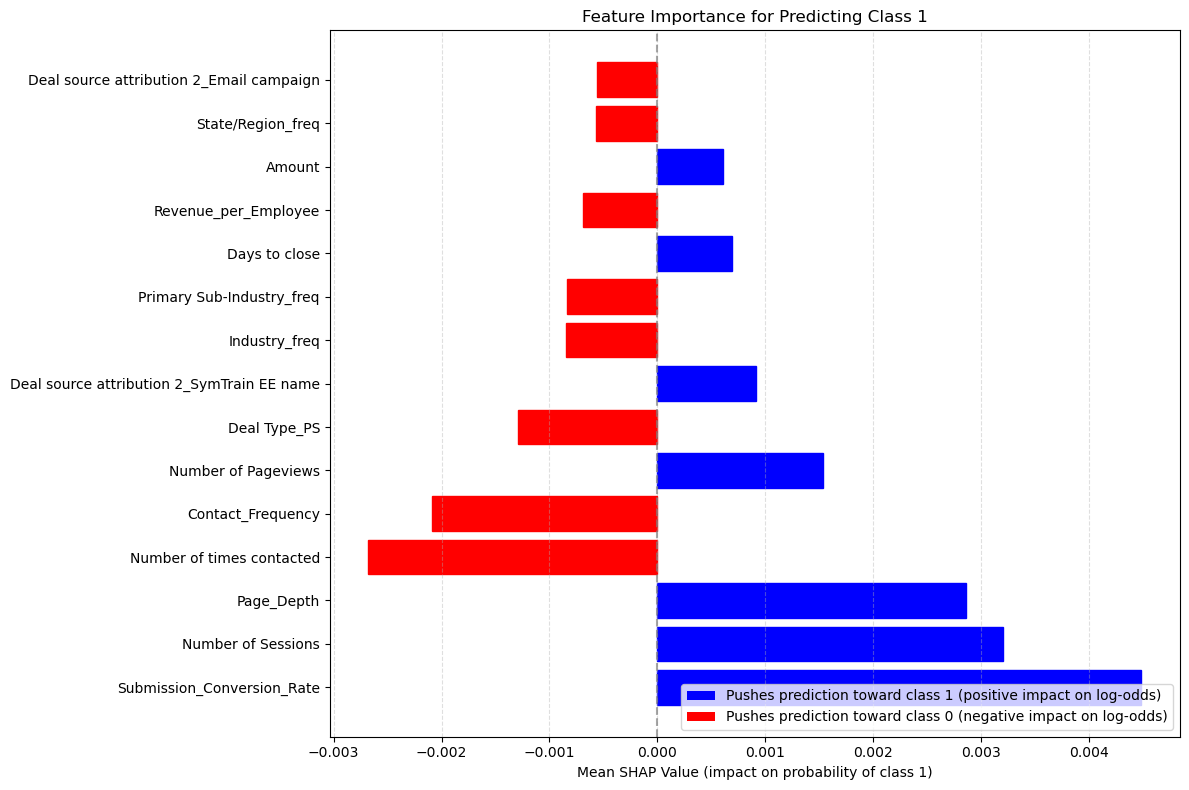


Top features increasing probability of class 1:
                                       Feature    Impact
13                  Submission_Conversion_Rate  0.004486
7                           Number of Sessions  0.003205
14                                  Page_Depth  0.002866
5                          Number of Pageviews  0.001536
56  Deal source attribution 2_SymTrain EE name  0.000910

Top features decreasing probability of class 1:
                      Feature    Impact
1   Number of times contacted -0.002678
11          Contact_Frequency -0.002091
16               Deal Type_PS -0.001294
61              Industry_freq -0.000842
60  Primary Sub-Industry_freq -0.000835


In [29]:
import shap
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Force inline plotting
%matplotlib inline

# Load model
rf_model = joblib.load("models/random_forest_model.pkl")

# Make sure data is clean and float
X_shap = X_train_balanced.astype('float64')

# Get feature names
feature_names = list(X_shap.columns) if hasattr(X_shap, 'columns') else [f"feature_{i}" for i in range(X_shap.shape[1])]

# Create explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)

# For the case where shap_values has shape (samples, features, classes)
# We want to focus on class 1 (positive class)
print(f"Shape of shap_values: {shap_values.shape}")

# Extract values for class 1 (positive class prediction)
class_idx = 1  # Index for positive class
# We need to extract the right dimension
if shap_values.shape[-1] == 2:  # If the last dimension has size 2 (for classes)
    # Get values for class 1 (index 1) across all samples and features
    class_values = shap_values[:, :, class_idx]
    print(f"Shape after selecting class {class_idx}: {class_values.shape}")
    
    # Calculate mean impact across all samples
    mean_values = np.mean(class_values, axis=0)
    print(f"Shape of mean values: {mean_values.shape}")
    
    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Impact': mean_values,
        'AbsImpact': np.abs(mean_values)
    })
    
    # Sort by absolute impact
    feature_importance = feature_importance.sort_values('AbsImpact', ascending=False)
    
    # Take top 15 features
    top_features = feature_importance.head(15)
    
    # Create bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(top_features)), top_features['Impact'])
    
    # Color bars based on positive/negative values
    for i, bar in enumerate(bars):
        if top_features.iloc[i]['Impact'] < 0:
            bar.set_color('red')
        else:
            bar.set_color('blue')
    
    # Set y-tick labels (feature names)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    
    # Add a vertical line at x=0
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    
    # Add labels and title
    plt.xlabel('Mean SHAP Value (impact on probability of class 1)')
    plt.title('Feature Importance for Predicting Class 1')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
    Patch(facecolor='blue', label='Pushes prediction toward class 1 (positive impact on log-odds)'),
    Patch(facecolor='red', label='Pushes prediction toward class 0 (negative impact on log-odds)')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    # Show grid lines for readability
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    
    # Tight layout and display
    plt.tight_layout()
    plt.show()
    
    # Print the top positive and negative features
    print("\nTop features increasing probability of class 1:")
    print(feature_importance[feature_importance['Impact'] > 0].head(5)[['Feature', 'Impact']])
    
    print("\nTop features decreasing probability of class 1:")
    print(feature_importance[feature_importance['Impact'] < 0].head(5)[['Feature', 'Impact']])
else:
    print("Unexpected shape for SHAP values. Please check your model and data.")